# Functions testing

## Research Project 2022

In [ ]:
import xarray 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


In [ ]:
def write_to_tif(data):
    """
    Function to convert data to tif file.
    Arguments:
        data:
    Returns:
        tif file
    """
    #if type data
    return

In [ ]:
def read_and_prep_parquet(path, purpose):
    """
    Function to read parquet and prepare as train or test data.
    Arguments:
        path: path to file.
        purpose: {'train', 'test', 'validate', 'predict'} purpose of file.
    Returns: train/test dataset and label array (specify output datatype!)
    """
    valid = {'train', 'test', 'validate', 'predict'}
    if purpose not in valid:
        raise ValueError("Purpose must be one of %r." % valid)

    df = pd.read_parquet(path)
    if purpose in ['train', 'test', 'validate']:
        df = df.loc[df['opt_value'] != -1] # remove mask
        df = df.fillna(-1) # fill values to be able to train
        X = df[['x', 'y', 'mw_value', 'col', 'row', 'v1', 'v2', 'v3', 'v4', 'v6', 'v7', 'v8', 'v9', 'mean', 'elevation_data']] # v5 is duplicated
        y = df[['opt_value']]
        return X, y
    else:
        df = df.fillna(-1) # fill values to be able to train
        X = df[['x', 'y', 'mw_value', 'col', 'row', 'v1', 'v2', 'v3', 'v4', 'v6', 'v7', 'v8', 'v9', 'mean', 'elevation_data']] # v5 is duplicated
        return X

In [ ]:
def get_rmse(y_real, y_predicted):
    return np.sqrt(mean_squared_error(y_real, y_predicted))


In [2]:
import xarray
path_elevation =  r"../Data/elevation_data/gimpdem_1km_compressed.tif"
data_elevation = xarray.open_dataarray(path_elevation)

In [19]:
import rasterio

def information(path_to_file):
    with rasterio.open(path_elevation) as src:
        print('BOUNDS:')
        print(f'    {src.bounds}')
        print('METADATA:')
        print(f'    {src.meta}')
        #print(src.crs)

    data = xarray.open_dataarray(path_elevation)
    print('MORE CRS INFO:')
    print(f'    {data.spatial_ref.crs_wkt}')
    print('RESOLUTION:')
    print(f'    {data.rio.resolution()}')

    return


# ----band data:----
# raster = rasterio.open(optical_path) #,masked=True)
#band_arr = raster.read(band_id) 

BOUNDS:
    BoundingBox(left=-637000.0, bottom=-3349000.0, right=850000.0, top=-662000.0)
METADATA:
    {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 1487, 'height': 2687, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(1000.0, 0.0, -637000.0,
       0.0, -1000.0, -662000.0)}
MORE CRS INFO:
    PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","3413"]]
RESOLUTION:
    (1000.0, -1000.0)


## Old functions 

In [ ]:
def cross_validation(df, columns, train_func, n_splits=5, hyperparameters=None):
    """
    Cross-validation with TimeSeriesSplit.

    Args:
        df (pandas.DataFrame): Full train/ test dataframe.

        columns (list of strings): List of columns to be used in training.

        train_func (function): Custom defined function for training and evaluating model.
                                E.g.: model_decisionTree()

        n_splits (int): Number of cv splits.

        hyperparameters (dict, optional): Dictionary with hyperparameters for model.

    Returns:
        list: Two list with <n_splits> RMSE scores for train and test data.
    """

    df.sort_values(by=["date"], inplace=True)  # sort df by time
    X = df[columns]
    y = df[["opt_value"]]

    rmse_train_list = []
    rmse_test_list = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for train_index, test_index in tqdm(tscv.split(X)):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        y_predicted_train, y_predicted_test = train_func(
            X_train, y_train, X_test, y_test, hyperparameters
        )

        rmse_train = get_rmse(y_train, y_predicted_train)
        rmse_test = get_rmse(y_test, y_predicted_test)

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)

    return rmse_train_list, rmse_test_list


def get_rmse(y_real, y_predicted):
    """
    Calculates RMSE score.

    Args:
        y_real (): real target values.

        y_predicted (): model predicted target values.

    Returns:
        float: RMSE score.
    """

    return np.sqrt(mean_squared_error(y_real, y_predicted))


def model_decisionTree(X_train, y_train, X_test, y_test, hyperparameters=None):
    """
    Trains model and predicts target values.

    Args:
        X_train (pandas.DataFrame): Dataframe with train data.

        y_train (pandas.DataFrame): Dataframe with train labels, one column.

        X_test (pandas.DataFrame): Dataframe with test data.

        y_test (pandas.DataFrame): Dataframe with test labels, one column.

        hyperparameters (dict, optional): Dictionary with model parameters.

    Returns:
        list: Two lists with predicted values for train and test set.
    """

    if hyperparameters:
        regressor = DecisionTreeRegressor(**hyperparameters)
    else:
        regressor = DecisionTreeRegressor(random_state=0)

    regressor.fit(X_train, y_train)
    y_predicted_train = regressor.predict(X_train)
    y_predicted_test = regressor.predict(X_test)

    return y_predicted_train, y_predicted_test


### Benchmark functions

In [4]:
def model_meanBenchmark(y_train, y_test):
    """
    Creates predictions for mean benchmark.

    Args:
        y_train (pandas.DataFrame): Dataframe with train labels, one column.

        y_test (pandas.DataFrame): Dataframe with test labels, one column.

    Returns:
        list: Lists with predicted values for test set.
    """

    y_predicted = np.full((1, len(y_test)), y_train.mean())[0]

    return y_predicted

In [5]:
def model_mwBenchmark(X_test):
    """
    Creates predictions for microwave benchmark by comparing the mw and opt datasets directly.

    Args:
        X_test (pandas.DataFrame): Dataframe with test data.

    Returns:
        list: Lists with predicted values for test set.
    """

    y_predicted = X_test['mw_value']

    return y_predicted

## Thesis 2023

In [6]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

import numpy as np
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

pd.options.mode.chained_assignment = None
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

import pickle
import matplotlib.pyplot as plt # to plot kmeans splits

### Data processing functions

In [2]:
def import_data(date_from:str, date_to:str, df_path:str):
    """
    Imports data and merges into one dataframe.

    Args:
        date_from (format: 'yyyy-mm-dd'): Period starting date (included).

        date_to (format: 'yyyy-mm-dd'): Period end date (included).

        df_path: Path to folder with daily data files.

    Returns:
        pandas.DataFrame: Dataframe with all merged data.
    """

    date_range = pd.date_range(date_from, date_to) # both ends included
    date_range = [str(day.date()) for day in date_range]
    df_list = []

    for melt_date in tqdm(date_range):
        try: # bc some days are empty
            file = pd.read_parquet(df_path + 'melt_'+ melt_date + '_extended.parquet.gzip', index= False) 
            df_list.append(file) # list of df
        except:
            continue
        
    df = pd.concat(df_list, axis=0) # concat af df to one
    del df_list
    return df

In [3]:
def remove_data(df, removeMaskedClouds = True, removeNoMelt = True):
    # remove -1 from mw:
    df = df[df['mw_value'] != -1]
    
    if removeMaskedClouds == True:
        # remove nan/-1 from opt:
        df = df[df['opt_value'] != -1]

    if removeNoMelt == True:
        # open file
        # join with file
        melt = pd.read_parquet(r"../Data/split_indexes/noMelt_indexes.parquet", index= False)
        df = df.merge(melt, how = 'left', on = ["y",'x'])
        df = df[df['melt'] == 1]
    return df

### Test

In [4]:
df_path = r"../Data/combined/dataframe_extended/"

date_from = '2019-07-01'
date_to = '2019-07-04'

In [5]:
data = import_data(date_from, date_to, df_path)
data=data[['x', 'y','mw_value', 'opt_value', 'date', 'mean_3']]
data = remove_data(data, removeMaskedClouds = True, removeNoMelt = True)

100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


In [12]:
class trainedModel:

    def __init__(self, model, hyperparameters):  
        self.model = model
        self.hyperparameters = hyperparameters # list of dictionaries with hyperparameters

    # def __cv_split_outer_loop(self, df):
    #     cv_split = pd.read_parquet(r"../Data/split_indexes/cv_split.parquet", index= False)
    #     df = df.merge(cv_split, how = 'left',  on = ['x', 'y'])
    #     return df

    # def __cv_split_inner_loop(self, df):
    #     kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df[['x','y']])
    #     df['inner_area'] = kmeans.labels_
    #     return df
    
    def __kmeans_split(self, df, loop, plot = False):
        # loop = 'inner' or 'outer'
        kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df[['x','y']])
        if loop == 'inner':
            df['inner_area'] = kmeans.labels_
        elif loop == 'outer':
            df['outer_area'] = kmeans.labels_

        if plot == True:
            print(df[loop+'_area'].value_counts())
            plt.scatter(df['x'], df['y'], c=df[loop+'_area'], edgecolor='none', s = 0.05)
            plt.show()
        return df
    
    def __train_test_split(self, df, columns, split_index):
        inner_train = df[df['inner_area'] != split_index]
        inner_test  = df[df['inner_area'] == split_index]
        train_X = inner_train[columns]
        train_y = inner_train[["opt_value"]]
        test_X = inner_test[columns]
        test_y = inner_test[["opt_value"]] 
        return train_X, train_y, test_X, test_y

    def __inner_loop_tune_hyperparameters(self, df, columns):
        all_inner_loops_hyperparameter_scores= []
        for inner_split in df['inner_area'].unique():
            inner_train_X, inner_train_y, inner_test_X, inner_test_y = self.__train_test_split(df, columns, inner_split)                
            hyperparameter_scores = []
            if isinstance(self.hyperparameters, list):
                for hyperparams in self.hyperparameters:
                    regressor = self.model(random_state=0, **hyperparams).fit(inner_train_X, inner_train_y)
                    y_predicted_test = regressor.predict(inner_test_X)
                    hyperparameter_scores.append(mean_squared_error(inner_test_y, y_predicted_test, squared=False))
            else:
                print('hyperparameters must be a list')
            all_inner_loops_hyperparameter_scores.append(hyperparameter_scores)
        mean_hyperparameters = np.mean(all_inner_loops_hyperparameter_scores, axis=0)
        best_inner_hyperparameters = self.hyperparameters[np.argmax(mean_hyperparameters)]
        return best_inner_hyperparameters
    
    def spatial_cv(self, df, columns):
        rmse_list_train = []
        rmse_list_test = []
        r2_list_train = []
        r2_list_test = []
        self.best_hyperparameters = []
        predictions_train = []
        predictions_test = []
        real_values_train = []
        real_values_test = []
        
        df = self.__kmeans_split(df, 'outer') #, plot = True #df = self.__cv_split_outer_loop(df)
        for outer_split in df['outer_area'].unique():
            #if outer_split == 1: # remove
            train = df[df['outer_area'] != outer_split]
            train = self.__kmeans_split(train, 'inner') #train = self.__cv_split_inner_loop(train)
            best_hyperparam= self.__inner_loop_tune_hyperparameters(train, columns)
            self.best_hyperparameters.append(best_hyperparam)
            
            train_X, train_y, test_X, test_y = self.__train_test_split(train, columns, outer_split)
            print(f'length train_X: {len(train_X)}, length train_y: {len(train_y)}, length test_X: {len(test_X)}, length test_y: {len(test_y)}')
            regressor = self.model(random_state=0, **best_hyperparam).fit(train_X, train_y)
            train_y_predicted = regressor.predict(train_X)
            test_y_predicted  = regressor.predict(test_X )
            predictions_train.append(train_y_predicted)
            predictions_test.append(test_y_predicted)
            real_values_train.append(train_y)
            real_values_test.append(test_y)

            rmse_list_train.append(mean_squared_error(train_y, train_y_predicted))
            rmse_list_test.append(mean_squared_error(test_y, test_y_predicted))
            r2_list_train.append(r2_score(train_y, train_y_predicted))
            r2_list_test.append(r2_score(test_y, test_y_predicted))

            # else: # tb removed
            #     continue
        # results:
        self.rmse_train = np.mean(rmse_list_train)
        self.rmse_std_train = np.std(rmse_list_train)
        self.rmse_test = np.mean(rmse_list_test)
        self.rmse_std_test = np.std(rmse_list_test)
        self.r2_train = np.mean(r2_list_train)
        self.r2_std_train = np.std(r2_list_train)
        self.r2_test = np.mean(r2_list_test)
        self.r2_std_test = np.std(r2_list_test)
        
        self.outer_loop_results = {'rmse_list_train': rmse_list_train,
                                   'rmse_list_test' : rmse_list_test,
                                   'r2_list_train'  : r2_list_train,
                                   'r2_list_test'   : r2_list_test}
        
        self.outer_loop_predictions = {'train_y_predicted': predictions_train,
                                       'test_y_predicted' : predictions_test}
        self.outer_loop_real_values = {'train_y': real_values_train,
                                        'test_y' : real_values_test}
        return

    def get_results(self):
        results = pd.DataFrame({'Metric': ['RMSE', 'RMSE_std', 'R2', 'R2_std'],
                                'Train': [self.rmse_train, self.rmse_std_train ,self.r2_train, self.r2_std_train],
                                'Test': [self.rmse_test, self.rmse_std_test, self.r2_test, self.r2_std_test]})
        print(results)
        return 
    
    def get_attributes(self):
        for attribute, value in self.__dict__.items():
            print(attribute, '=', value)

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file, pickle.HIGHEST_PROTOCOL)
        return

In [13]:
hyp = [{'max_depth':7, 'criterion': 'squared_error'}, {'max_depth':4, 'criterion': 'squared_error'}]
dt = trainedModel(model = DecisionTreeRegressor, hyperparameters = hyp )

2    1005514
0     902264
4     593832
1     554145
3     409458
Name: outer_area, dtype: int64


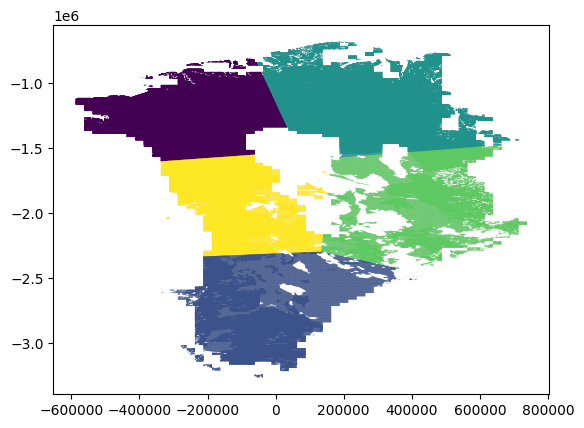

length train_X: 2111739, length train_y: 2111739, length test_X: 347960, length test_y: 347960
length train_X: 2159733, length train_y: 2159733, length test_X: 403216, length test_y: 403216
length train_X: 2514439, length train_y: 2514439, length test_X: 541316, length test_y: 541316
length train_X: 2389462, length train_y: 2389462, length test_X: 481919, length test_y: 481919
length train_X: 2590000, length train_y: 2590000, length test_X: 321068, length test_y: 321068


In [14]:
columns = ['x', 'y','mw_value', 'mean_3']
dt.spatial_cv(data, columns)

In [15]:
dt.get_attributes()

model = <class 'sklearn.tree._classes.DecisionTreeRegressor'>
hyperparameters = [{'max_depth': 7, 'criterion': 'squared_error'}, {'max_depth': 4, 'criterion': 'squared_error'}]
best_hyperparameters = [{'max_depth': 7, 'criterion': 'squared_error'}, {'max_depth': 4, 'criterion': 'squared_error'}, {'max_depth': 7, 'criterion': 'squared_error'}, {'max_depth': 7, 'criterion': 'squared_error'}, {'max_depth': 7, 'criterion': 'squared_error'}]
rmse_train = 0.067023010758099
rmse_std_train = 0.00637549230282518
rmse_test = 0.09727095113642321
rmse_std_test = 0.03518824307277278
r2_train = 0.601139292735412
r2_std_train = 0.07008275109140152
r2_test = -0.6378093908110802
r2_std_test = 1.5755597463821835
outer_loop_results = {'rmse_list_train': [0.05719315681506576, 0.07729814799348818, 0.06704292989909487, 0.06611164841065172, 0.06746917067219445], 'rmse_list_test': [0.07428144953056068, 0.16151704455224708, 0.10500138024508325, 0.08451117209591623, 0.06104370925830881], 'r2_list_train': [0.673

In [19]:
def save_object(obj, filename):
    filename = r'../Models/' + filename + '.pkl'
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
    return obj

In [20]:
save_object(dt, 'dt.pkl')

In [25]:
from functions_training_pipeline import trainedModel

### Older testing

In [1]:


a, b = cross_validation(df, ['mw_value', 'mean'], model_decisionTree, n_splits = 5, hyperparameters = None)


NameError: name 'import_data' is not defined

In [25]:
df = import_data(date_from, date_to, df_path)
df.isna().sum()

100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


x                     0
y                     0
mw_value              0
opt_value             0
col                   0
row                   0
v1                14044
v2                 6648
v3                14036
v4                 7576
v5                    0
v6                 7576
v7                14036
v8                 6648
v9                14044
date                  0
mean                  0
elevation_data        0
dtype: int64

In [27]:
df = df[df['mw_value'] != -1]

In [ ]:
def convert_to_tif(data, path_file_metadata, path_out):
    """
    Function to convert data to tif file.
    Arguments:
        data: new file
        path_file_metadata: tif file with metadata matching expected output tif file
        path_out: output tif file destination and name path
    Returns:
        .tif file
    """
    with rasterio.open(path_file_metadata) as src:
        kwargs1 = src.meta.copy()

    with rasterio.open(path_out, "w", **kwargs1) as dst:
        dst.write_band(1, data)  # numpy array or xarray
    return

In [ ]:
def save_prediction_tif(X_pred, y_predicted, path_out):
    """
    Function to write predictions to .tif.
    Arguments:
        X_pred: data to be predicted on.
        y_predicted: predicted labels in array, or pandas series.
        path_out: path to save .tif file with file name.
    Returns: No return, writes data to path.
    """
    # join prediction and coordinates (row, col)
    X_pred["prediction"] = y_predicted

    # original matrix shape:
    nan_matrix = np.full((2663, 1462), np.nan)

    for row in tqdm(X_pred.iterrows()):  # fix progress bar?
        row_index = int(row[1]["row"])
        col_index = int(row[1]["col"])
        pred_val = row[1]["prediction"]
        nan_matrix[row_index][col_index] = pred_val

    # file to take reference metadata from is interpolated transformed file
    path_metadata_reference = r"../Data/microwave-rs/mw_interpolated/2019-07-01_mw.tif"

    convert_to_tif(nan_matrix, path_metadata_reference, path_out)

    return
